<a href="https://colab.research.google.com/github/tanmay143/Cotton-infection-classificaation/blob/main/Visualization_With_colors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install pylibjpeg pylibjpeg-libjpeg pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [2]:
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path="/content/drive/MyDrive/CT_SCANS_N_REPORTS"
patients=os.listdir(path)

In [5]:
for i,patient in enumerate(patients[:1]):
    t=path+'/'+patient+'/CT/2'
    if i == 3:
      t=path+'/'+patient+'/CT/1'
    slices = [(dcmread(t + '/' + s)) for s in os.listdir(t)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

In [6]:
mask= [(slice.pixel_array < 1500) for slice in slices]

In [8]:
mask=np.vectorize(clear_border,signature='(n,m)->(n,m)')(mask)
mask_labeled=np.vectorize(label, signature='(n,m)->(n,m)')(mask)

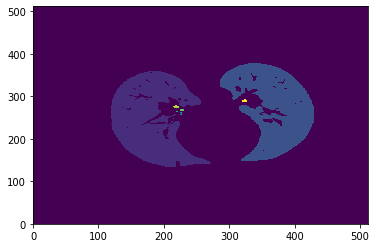

In [10]:
plt.pcolormesh(mask_labeled[50])

In [17]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y > 0.8*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [19]:
mask_l=np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask_labeled)

In [20]:
im = zoom(1*(mask_l), (0.35,0.35,0.35))

In [21]:
z, y, x = [np.arange(i) for i in im.shape]

In [23]:
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')

In [24]:
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.transpose(im,(1,2,0)).flatten(),
    isomin=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.write_html("test.html")